# [금융,경제 데이터 애플리케이션]

- Cross Section(크로스섹션) : 시간상 고정된 위치에서 존재하는 데이터를 나타내기 위한 방법.[예시: S&P 500 지수의 모든 주식 종목의 종가] 

In [1]:
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(12, 4))
np.set_printoptions(precision=4)
from pandas_datareader import data as web
import fix_yahoo_finance as yf

pd.options.display.notebook_repr_html = False

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## 11.1: 데이터 준비(Data munging topics)

### 11.1.1: 시계열과 크로스 섹션 정렬(Time series and cross-section alignment)

In [2]:
close_px = pd.read_csv('./ch11/stock_px.csv', parse_dates=True, index_col=0)
volume = pd.read_csv('./ch11/volume.csv', parse_dates=True, index_col=0)
prices = close_px.loc['2011-09-05':'2011-09-14',['AAPL','JNJ','SPX','XOM']]
volume = volume.loc['2011-09-05':'2011-09-12',['AAPL','JNJ','SPX','XOM']]

In [4]:
prices
volume

              AAPL    JNJ      SPX    XOM
2011-09-06  379.74  64.64  1165.24  71.15
2011-09-07  383.93  65.43  1198.62  73.65
2011-09-08  384.14  64.95  1185.90  72.82
2011-09-09  377.48  63.64  1154.23  71.01
2011-09-12  379.94  63.59  1162.27  71.84
2011-09-13  384.62  63.61  1172.87  71.65
2011-09-14  389.30  63.73  1188.68  72.64

                  AAPL         JNJ           SPX         XOM
2011-09-06  18173500.0  15848300.0  5.103980e+09  25416300.0
2011-09-07  12492000.0  10759700.0  4.441040e+09  23108400.0
2011-09-08  14839800.0  15551500.0  4.465170e+09  22434800.0
2011-09-09  20171900.0  17008200.0  4.586370e+09  27969100.0
2011-09-12  16697300.0  13448200.0  5.168550e+09  26205800.0

In [5]:
# 거래량 
prices * volume

                    AAPL           JNJ           SPX           XOM
2011-09-06  6.901205e+09  1.024434e+09  5.947362e+12  1.808370e+09
2011-09-07  4.796054e+09  7.040072e+08  5.323119e+12  1.701934e+09
2011-09-08  5.700561e+09  1.010070e+09  5.295245e+12  1.633702e+09
2011-09-09  7.614489e+09  1.082402e+09  5.293726e+12  1.986086e+09
2011-09-12  6.343972e+09  8.551710e+08  6.007251e+12  1.882625e+09
2011-09-13           NaN           NaN           NaN           NaN
2011-09-14           NaN           NaN           NaN           NaN

In [6]:
# 단일 거래에 대한, 거래된 한주당 평균 주가.
vwap = (prices * volume).sum() / volume.sum()
vwap

AAPL     380.655181
JNJ       64.394769
SPX     1172.588832
XOM       72.024288
dtype: float64

In [7]:
vwap.dropna()

AAPL     380.655181
JNJ       64.394769
SPX     1172.588832
XOM       72.024288
dtype: float64

In [8]:
# SPX는 발행주식(volume)이 없으므로 명시적으로 배제가능 > 데이터 정렬시 df의 align
# align : 새롭게 색인된 두 객체의 튜플을 반환.
prices.align(volume, join='inner')

(              AAPL    JNJ      SPX    XOM
 2011-09-06  379.74  64.64  1165.24  71.15
 2011-09-07  383.93  65.43  1198.62  73.65
 2011-09-08  384.14  64.95  1185.90  72.82
 2011-09-09  377.48  63.64  1154.23  71.01
 2011-09-12  379.94  63.59  1162.27  71.84,
                   AAPL         JNJ           SPX         XOM
 2011-09-06  18173500.0  15848300.0  5.103980e+09  25416300.0
 2011-09-07  12492000.0  10759700.0  4.441040e+09  23108400.0
 2011-09-08  14839800.0  15551500.0  4.465170e+09  22434800.0
 2011-09-09  20171900.0  17008200.0  4.586370e+09  27969100.0
 2011-09-12  16697300.0  13448200.0  5.168550e+09  26205800.0)

In [9]:
s1 = Series(range(3), index=['a','b','c'])
s2 = Series(range(4), index=['d','b','c','e'])
s3 = Series(range(3), index=['f','a','c'])
DataFrame({'one':s1, 'two': s2, 'three': s3})

   one  three  two
a  0.0    1.0  NaN
b  1.0    NaN  1.0
c  2.0    2.0  2.0
d  NaN    NaN  0.0
e  NaN    NaN  3.0
f  NaN    0.0  NaN

In [10]:
DataFrame({'one':s1, 'two':s2, 'three':s3}, index=list('face'))

   one  three  two
f  NaN    0.0  NaN
a  0.0    1.0  NaN
c  2.0    2.0  2.0
e  NaN    NaN  3.0

### 11.1.2: 다른빈도를 가지는 시계열 연산(Operations with time series of different frequencies)

In [11]:
ts1 = Series(np.random.randn(3),
            index=pd.date_range('2012-06-13', periods=3, freq='W-WED'))
ts1

2012-06-13   -0.204708
2012-06-20    0.478943
2012-06-27   -0.519439
Freq: W-WED, dtype: float64

In [12]:
ts1.resample('B')
ts1.resample('B').ffill()

DatetimeIndexResampler [freq=<BusinessDay>, axis=0, closed=left, label=left, convention=start, base=0]

2012-06-13   -0.204708
2012-06-14   -0.204708
2012-06-15   -0.204708
2012-06-18   -0.204708
2012-06-19   -0.204708
2012-06-20    0.478943
2012-06-21    0.478943
2012-06-22    0.478943
2012-06-25    0.478943
2012-06-26    0.478943
2012-06-27   -0.519439
Freq: B, dtype: float64

In [13]:
dates = pd.DatetimeIndex(['2012-6-12', '2012-6-17', '2012-6-18',
                          '2012-6-21', '2012-6-22', '2012-6-29'])
ts2 = Series(np.random.randn(6), index=dates)
ts2

2012-06-12   -0.555730
2012-06-17    1.965781
2012-06-18    1.393406
2012-06-21    0.092908
2012-06-22    0.281746
2012-06-29    0.769023
dtype: float64

In [14]:
# ts2로 다시 인덱싱 하겠음.
ts1.reindex(ts2.index, method='ffill')
ts2 + ts1.reindex(ts2.index, method='ffill')

2012-06-12         NaN
2012-06-17   -0.204708
2012-06-18   -0.204708
2012-06-21    0.478943
2012-06-22    0.478943
2012-06-29   -0.519439
dtype: float64

2012-06-12         NaN
2012-06-17    1.761073
2012-06-18    1.188698
2012-06-21    0.571851
2012-06-22    0.760689
2012-06-29    0.249584
dtype: float64

#### 타임스탬프 대신 Period 사용하기.(Using periods instead of timestamps)

In [15]:
gdp = Series([1.78, 1.94, 2.08, 2.01, 2.15, 2.31, 2.46],
             index=pd.period_range('1984Q2', periods=7, freq='Q-SEP'))
infl = Series([0.025, 0.045, 0.037, 0.04],
              index=pd.period_range('1982', periods=4, freq='A-DEC'))
gdp
infl

1984Q2    1.78
1984Q3    1.94
1984Q4    2.08
1985Q1    2.01
1985Q2    2.15
1985Q3    2.31
1985Q4    2.46
Freq: Q-SEP, dtype: float64

1982    0.025
1983    0.045
1984    0.037
1985    0.040
Freq: A-DEC, dtype: float64

In [16]:
infl_q = infl.asfreq('Q-SEP', how='end')
infl_q

1983Q1    0.025
1984Q1    0.045
1985Q1    0.037
1986Q1    0.040
Freq: Q-SEP, dtype: float64

In [17]:
infl_q.reindex(gdp.index, method='ffill')
infl_q

1984Q2    0.045
1984Q3    0.045
1984Q4    0.045
1985Q1    0.037
1985Q2    0.037
1985Q3    0.037
1985Q4    0.037
Freq: Q-SEP, dtype: float64

1983Q1    0.025
1984Q1    0.045
1985Q1    0.037
1986Q1    0.040
Freq: Q-SEP, dtype: float64

### 11.3: 일별시간과 현재 최신데이터 선택하기(Time of day and "as of" data selection).

In [20]:
# 주식장의 범위와 시계열을 생성.
rng = pd.date_range('2012-06-01 09:30', '2012-06-01 15:59', freq='T')
# 5일간 09:30에서 15:59의 시계열을 생성.
rng = rng.append([rng + pd.offsets.BDay(i) for i in range(1,4)])
ts = Series(np.arange(len(rng), dtype=float), index=rng)
ts

2012-06-01 09:30:00       0.0
2012-06-01 09:31:00       1.0
2012-06-01 09:32:00       2.0
2012-06-01 09:33:00       3.0
2012-06-01 09:34:00       4.0
2012-06-01 09:35:00       5.0
                        ...  
2012-06-06 15:54:00    1554.0
2012-06-06 15:55:00    1555.0
2012-06-06 15:56:00    1556.0
2012-06-06 15:57:00    1557.0
2012-06-06 15:58:00    1558.0
2012-06-06 15:59:00    1559.0
Length: 1560, dtype: float64

In [23]:
# 시간대의 값 추출.
from datetime import time
ts[time(10, 0)] # 10시

2012-06-01 10:00:00      30.0
2012-06-04 10:00:00     420.0
2012-06-05 10:00:00     810.0
2012-06-06 10:00:00    1200.0
dtype: float64

In [27]:
# 두 시간사이의 값.
ts.between_time(time(10,0), time(10,1)) # 10시~10시 1분

2012-06-01 10:00:00      30.0
2012-06-01 10:01:00      31.0
2012-06-04 10:00:00     420.0
2012-06-04 10:01:00     421.0
2012-06-05 10:00:00     810.0
2012-06-05 10:01:00     811.0
2012-06-06 10:00:00    1200.0
2012-06-06 10:01:00    1201.0
dtype: float64

In [29]:
np.random.seed(12346)

In [31]:
# 정확히 오전 10시에 데이터가 존재하지 않는 경우의 시간 조히ㅚ.
indexer = np.sort(np.random.permutation(len(ts))[700:])
irr_ts = ts.copy()
irr_ts[indexer] = np.nan
irr_ts['2012-06-01 09:50':'2012-06-01 10:00']

2012-06-01 09:50:00    20.0
2012-06-01 09:51:00    21.0
2012-06-01 09:52:00    22.0
2012-06-01 09:53:00    23.0
2012-06-01 09:54:00     NaN
2012-06-01 09:55:00    25.0
2012-06-01 09:56:00     NaN
2012-06-01 09:57:00     NaN
2012-06-01 09:58:00     NaN
2012-06-01 09:59:00     NaN
2012-06-01 10:00:00     NaN
dtype: float64

In [33]:
# asof에 타임스팸프 배열을 넘기면 해당 시점 혹은 직전의 유효한 값이 담긴 배열을 얻을 수 있음.
# 매일 오전 10시의 날짜범위를 만들고 asof로 매서드를 넘기면 해당시점에 정확한 값이 없어도,
# 가장 최근의 유효한 값이 담긴 배열을 얻을 수 있음.
selection = pd.date_range('2012-06-01 10:00', periods=4, freq='B')
irr_ts.asof(selection)

2012-06-01 10:00:00      25.0
2012-06-04 10:00:00     418.0
2012-06-05 10:00:00     809.0
2012-06-06 10:00:00    1200.0
Freq: B, dtype: float64

### 11.4: 데이터와 함께 나누기(Splicing together data sources)
- 1) 어떤 데이터 원본(단일 시계열이나 시계열 모음)을 특정 시점의 데이터로 변환.
- 2) 다른 시계열을 사용해서 단일 시계열의 시작, 중간 혹은 끝부분에 누락된 값 채워넣기.
- 3) 데이터를 국가 혹은 자산지표 등의 기준으로 분류하여 대체하기.

In [40]:
# 1) 2개의 TimeSeries나 DataFrame 객체를 pandas.concat을 이용 
# > 한 묶음의 시계열의 데이터 -> 하나의 시계열
data1 = DataFrame(np.ones((6,3), dtype=float),
                  columns=['a','b','c'],
                  index=pd.date_range('6/12/2012', periods=6))
data2 = DataFrame(np.ones((6,3), dtype=float)*2,
                  columns=['a','b','c'],
                  index=pd.date_range('6/13/2012', periods=6))
spliced = pd.concat([data1.loc[:'2012-06-14'], data2.loc['2012-06-15':]])
data1
data2
spliced

              a    b    c
2012-06-12  1.0  1.0  1.0
2012-06-13  1.0  1.0  1.0
2012-06-14  1.0  1.0  1.0
2012-06-15  1.0  1.0  1.0
2012-06-16  1.0  1.0  1.0
2012-06-17  1.0  1.0  1.0

              a    b    c
2012-06-13  2.0  2.0  2.0
2012-06-14  2.0  2.0  2.0
2012-06-15  2.0  2.0  2.0
2012-06-16  2.0  2.0  2.0
2012-06-17  2.0  2.0  2.0
2012-06-18  2.0  2.0  2.0

              a    b    c
2012-06-12  1.0  1.0  1.0
2012-06-13  1.0  1.0  1.0
2012-06-14  1.0  1.0  1.0
2012-06-15  2.0  2.0  2.0
2012-06-16  2.0  2.0  2.0
2012-06-17  2.0  2.0  2.0
2012-06-18  2.0  2.0  2.0

In [43]:
# data2에만 데이터가 있고, data1은 없는 경우.
data2 = DataFrame(np.ones((6, 4), dtype=float) * 2,
                  columns=['a', 'b', 'c', 'd'],
                  index=pd.date_range('6/13/2012', periods=6))
spliced = pd.concat([data1.loc[:'2012-06-14'], data2.loc['2012-06-15':]])
spliced

              a    b    c    d
2012-06-12  1.0  1.0  1.0  NaN
2012-06-13  1.0  1.0  1.0  NaN
2012-06-14  1.0  1.0  1.0  NaN
2012-06-15  2.0  2.0  2.0  2.0
2012-06-16  2.0  2.0  2.0  2.0
2012-06-17  2.0  2.0  2.0  2.0
2012-06-18  2.0  2.0  2.0  2.0

In [45]:
# combine_first로 d 이전 컬럼내역을 채울 수 있음
spliced_filled = spliced.combine_first(data2)
spliced_filled

              a    b    c    d
2012-06-12  1.0  1.0  1.0  NaN
2012-06-13  1.0  1.0  1.0  2.0
2012-06-14  1.0  1.0  1.0  2.0
2012-06-15  2.0  2.0  2.0  2.0
2012-06-16  2.0  2.0  2.0  2.0
2012-06-17  2.0  2.0  2.0  2.0
2012-06-18  2.0  2.0  2.0  2.0

In [47]:
spliced.update(data2, overwrite=False) # 누락된값 갱신 : overwrite=False

In [49]:
spliced

              a    b    c    d
2012-06-12  1.0  1.0  1.0  NaN
2012-06-13  1.0  1.0  1.0  2.0
2012-06-14  1.0  1.0  1.0  2.0
2012-06-15  2.0  2.0  2.0  2.0
2012-06-16  2.0  2.0  2.0  2.0
2012-06-17  2.0  2.0  2.0  2.0
2012-06-18  2.0  2.0  2.0  2.0

In [51]:
cp_spliced = spliced.copy()
cp_spliced[['a','c']] = data1[['a','c']] # 컬럼 일부 치환.
cp_spliced

              a    b    c    d
2012-06-12  1.0  1.0  1.0  NaN
2012-06-13  1.0  1.0  1.0  2.0
2012-06-14  1.0  1.0  1.0  2.0
2012-06-15  1.0  2.0  1.0  2.0
2012-06-16  1.0  2.0  1.0  2.0
2012-06-17  1.0  2.0  1.0  2.0
2012-06-18  NaN  2.0  NaN  2.0

### 11.1.5: 수익지수와 누적수익(Return indexes and cumulative returns)

In [59]:
# 2011년~2012년 애플사의 주식 : 수익지수와 누적수익 알아보기.
from pandas_datareader import data as web
price = web.get_data_yahoo('AAPL', '2011-01-01')['Adj Close']
price[-5:]

Date
2018-04-02    166.679993
2018-04-03    168.389999
2018-04-04    171.610001
2018-04-05    172.800003
2018-04-06    168.380005
Name: Adj Close, dtype: float64

In [61]:
# 애플은 배당이 없었기 때문에 그냥 주가 변화율로 누적수익률을 계산.
price['2011-10-03'] / price['2011-03-01'] - 1

0.072400201130253361

In [74]:
# 배당금 지급 주식시에는 재투자 수익 제외 > cumprod 사용으로 수익지수 계산
returns = price.pct_change()
ret_index = (1+returns).cumprod()
ret_index[0] = 1 # 처음값 1
ret_index

Date
2010-12-31    1.000000
2011-01-03    1.021732
2011-01-04    1.027065
2011-01-05    1.035466
2011-01-06    1.034629
2011-01-07    1.042039
                ...   
2018-03-29    5.378571
2018-04-02    5.343308
2018-04-03    5.398126
2018-04-04    5.501350
2018-04-05    5.539499
2018-04-06    5.397805
Name: Adj Close, Length: 1828, dtype: float64

In [75]:
# 구한 수로 특정기간동안의 누적수익 계산 가능.
m_returns = ret_index.resample('BM').last().pct_change()
m_returns['2012']
m_returns['2013']
m_returns['2014']
m_returns['2015']
m_returns['2016']
m_returns['2017']
m_returns['2018']

Date
2012-01-31    0.127111
2012-02-29    0.188311
2012-03-30    0.105283
2012-04-30   -0.025969
2012-05-31   -0.010702
2012-06-29    0.010853
2012-07-31    0.045822
2012-08-31    0.122801
2012-09-28    0.002796
2012-10-31   -0.107600
2012-11-30    0.015453
2012-12-31   -0.090743
Freq: BM, Name: Adj Close, dtype: float64

Date
2013-01-31   -0.144089
2013-02-28    0.010033
2013-03-29    0.002855
2013-04-30    0.000271
2013-05-31    0.064703
2013-06-28   -0.118293
2013-07-31    0.141225
2013-08-30    0.128473
2013-09-30   -0.021489
2013-10-31    0.096382
2013-11-29    0.108898
2013-12-31    0.008902
Freq: BM, Name: Adj Close, dtype: float64

Date
2014-01-31   -0.107697
2014-02-28    0.096906
2014-03-31    0.019953
2014-04-30    0.099396
2014-05-30    0.116113
2014-06-30    0.027662
2014-07-31    0.028731
2014-08-29    0.077509
2014-09-30   -0.017073
2014-10-31    0.071960
2014-11-28    0.105979
2014-12-31   -0.071891
Freq: BM, Name: Adj Close, dtype: float64

Date
2015-01-30    0.061424
2015-02-27    0.100777
2015-03-31   -0.031372
2015-04-30    0.005786
2015-05-29    0.045339
2015-06-30   -0.037227
2015-07-31   -0.032927
2015-08-31   -0.066196
2015-09-30   -0.021816
2015-10-30    0.083409
2015-11-30   -0.005804
2015-12-31   -0.110228
Freq: BM, Name: Adj Close, dtype: float64

Date
2016-01-29   -0.075242
2016-02-29   -0.001287
2016-03-31    0.127211
2016-04-29   -0.139921
2016-05-31    0.071773
2016-06-30   -0.042660
2016-07-29    0.090063
2016-08-31    0.023652
2016-09-30    0.065504
2016-10-31    0.004334
2016-11-30   -0.021601
2016-12-30    0.047955
Freq: BM, Name: Adj Close, dtype: float64

Date
2017-01-31    0.047746
2017-02-28    0.133778
2017-03-31    0.048690
2017-04-28   -0.000070
2017-05-31    0.067808
2017-06-30   -0.057214
2017-07-31    0.032704
2017-08-31    0.106999
2017-09-29   -0.060244
2017-10-31    0.096808
2017-11-30    0.020278
2017-12-29   -0.015246
Freq: BM, Name: Adj Close, dtype: float64

Date
2018-01-31   -0.010636
2018-02-28    0.068185
2018-03-30   -0.058051
2018-04-30    0.003576
Freq: BM, Name: Adj Close, dtype: float64

In [76]:
# 구한 수로 특정기간동안의 누적수익 계산 가능.
m_rets = (1+returns).resample('M',kind='period').prod()-1 
m_rets['2012']
m_rets['2013']
m_rets['2014']
m_rets['2015']
m_rets['2016']
m_rets['2017']
m_rets['2018']

Date
2012-01    0.127111
2012-02    0.188311
2012-03    0.105283
2012-04   -0.025969
2012-05   -0.010702
2012-06    0.010853
2012-07    0.045822
2012-08    0.122801
2012-09    0.002796
2012-10   -0.107600
2012-11    0.015453
2012-12   -0.090743
Freq: M, Name: Adj Close, dtype: float64

Date
2013-01   -0.144089
2013-02    0.010033
2013-03    0.002855
2013-04    0.000271
2013-05    0.064703
2013-06   -0.118293
2013-07    0.141225
2013-08    0.128473
2013-09   -0.021489
2013-10    0.096382
2013-11    0.108898
2013-12    0.008902
Freq: M, Name: Adj Close, dtype: float64

Date
2014-01   -0.107697
2014-02    0.096906
2014-03    0.019953
2014-04    0.099396
2014-05    0.116113
2014-06    0.027662
2014-07    0.028731
2014-08    0.077509
2014-09   -0.017073
2014-10    0.071960
2014-11    0.105979
2014-12   -0.071891
Freq: M, Name: Adj Close, dtype: float64

Date
2015-01    0.061424
2015-02    0.100777
2015-03   -0.031372
2015-04    0.005786
2015-05    0.045339
2015-06   -0.037227
2015-07   -0.032927
2015-08   -0.066196
2015-09   -0.021816
2015-10    0.083409
2015-11   -0.005804
2015-12   -0.110228
Freq: M, Name: Adj Close, dtype: float64

Date
2016-01   -0.075242
2016-02   -0.001287
2016-03    0.127211
2016-04   -0.139921
2016-05    0.071773
2016-06   -0.042660
2016-07    0.090063
2016-08    0.023652
2016-09    0.065504
2016-10    0.004334
2016-11   -0.021601
2016-12    0.047955
Freq: M, Name: Adj Close, dtype: float64

Date
2017-01    0.047746
2017-02    0.133778
2017-03    0.048690
2017-04   -0.000070
2017-05    0.067808
2017-06   -0.057214
2017-07    0.032704
2017-08    0.106999
2017-09   -0.060244
2017-10    0.096808
2017-11    0.020278
2017-12   -0.015246
Freq: M, Name: Adj Close, dtype: float64

Date
2018-01   -0.010636
2018-02    0.068185
2018-03   -0.058051
2018-04    0.003576
Freq: M, Name: Adj Close, dtype: float64

In [78]:
# 배당일과 배당비율을 안다면 일별 총 수익에 다음처럼 더하면 됨.
# returns[dividend_dates] += dividend_pcts

## 11.2: 그룹변환과 분석(Group transforms and analysis)

In [16]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 10
np.random.seed(12345)

In [17]:
# 임의로 1000개 주식종목 생성.
import random; random.seed(0)
import string
N = 1000
def rands(n):
    choices = string.ascii_uppercase
    return ''.join([random.choice(choices) for _ in range(n)])
tickers = np.array([rands(5) for _ in range(N)])

In [18]:
# 주식종목에 사용할 3개 컬럼을 가지는 dataframe 생성.
M = 500
df = DataFrame({'Momentum' : np.random.randn(M) / 200 + 0.03,
                'Value' : np.random.randn(M) / 200 + 0.08,
                'ShortInterest' : np.random.randn(M) / 200 - 0.02},
                index=tickers[:M])
df

       Momentum  ShortInterest     Value
MYNBI  0.028976      -0.024918  0.076191
QPMZJ  0.032395      -0.015345  0.078342
PLSGQ  0.027403      -0.024058  0.071243
EJEYD  0.027221      -0.029151  0.083144
TZIRW  0.039829      -0.020694  0.081413
ZTEJD  0.036967      -0.018330  0.073309
XCVKP  0.030465      -0.017557  0.077497
RDLNK  0.031409      -0.020890  0.080608
TUGRP  0.033845      -0.009388  0.088542
OQIBZ  0.036232      -0.019694  0.075145
RACXM  0.035036      -0.015579  0.076903
WZVUA  0.023519      -0.023043  0.076366
TPKHX  0.031375      -0.020360  0.086108
KWCGS  0.031145      -0.017280  0.082518
HHZEZ  0.036765      -0.018381  0.073061
ROCCK  0.034432      -0.028417  0.081024
QPDJR  0.019992      -0.017366  0.083019
JWDRK  0.028141      -0.010706  0.082728
RGZTR  0.038345      -0.022742  0.081177
SJOCT  0.027807      -0.021397  0.080559
ZMKSH  0.027301      -0.020106  0.073742
JFGFB  0.032385      -0.021440  0.065253
TVIPC  0.046245      -0.019554  0.083173
CVYEE  0.024894 

In [19]:
# 산업테마 생성.
ind_names = np.array(['FINANCIAL', 'TECH'])
sampler = np.random.randint(0, len(ind_names), N)
industries = Series(ind_names[sampler], index=tickers,
                    name='industry')

In [20]:
# 산업테마별 그룹집계 및 변환
by_industry = df.groupby(industries)
by_industry.mean()

           Momentum  ShortInterest     Value
industry                                    
FINANCIAL  0.029485      -0.020739  0.079929
TECH       0.030407      -0.019609  0.080113

In [21]:
by_industry.describe()

          Momentum                                            ...     \
             count      mean       std       min       25%    ...      
industry                                                      ...      
FINANCIAL    246.0  0.029485  0.004802  0.017210  0.026263    ...      
TECH         254.0  0.030407  0.005303  0.016778  0.026456    ...      

              Value                                          
                min       25%       50%       75%       max  
industry                                                     
FINANCIAL  0.067025  0.076638  0.079804  0.082718  0.093334  
TECH       0.065253  0.076737  0.080296  0.083353  0.093081  

[2 rows x 24 columns]

In [22]:
# 산업별 표준화 함수
def zscore(group):
    return (group - group.mean() / group.std())

df_stand = by_industry.apply(zscore)

In [26]:
df_stand.groupby(industries).agg(['mean','std'])

           Momentum           ShortInterest                Value          
               mean       std          mean       std       mean       std
industry                                                                  
FINANCIAL -6.111162  0.004802      4.139174  0.004986 -17.493166  0.004548
TECH      -5.703876  0.005303      3.844630  0.005074 -16.315139  0.004886

In [28]:
# 산업 테마별 순위
ind_rank = by_industry.rank(ascending=False)
ind_rank.groupby(industries).agg(['min','max'])

          Momentum        ShortInterest        Value       
               min    max           min    max   min    max
industry                                                   
FINANCIAL      1.0  246.0           1.0  246.0   1.0  246.0
TECH           1.0  254.0           1.0  254.0   1.0  254.0

In [55]:
# 산업순위와 표준화
by_industry.apply(lambda x : zscore(x.rank()))

         Momentum  ShortInterest       Value
MYNBI  115.264432      52.264432   50.264432
QPMZJ  178.264432     214.264432   96.264432
PLSGQ   83.264432      62.264432    2.264432
EJEYD   80.264432       6.264432  192.264432
TZIRW  241.264543     106.264543  153.264543
ZTEJD  228.264543     152.264543   20.264543
XCVKP  120.264543     172.264543   77.264543
RDLNK  143.264543     102.264543  133.264543
TUGRP  198.264432     240.264432  234.264432
OQIBZ  222.264432     147.264432   28.264432
RACXM  209.264432     211.264432   63.264432
WZVUA   20.264432      77.264432   55.264432
TPKHX  142.264543     114.264543  222.264543
KWCGS  136.264543     180.264543  171.264543
HHZEZ  231.264432     164.264432   10.264432
ROCCK  201.264432      14.264432  152.264432
QPDJR    5.264543     177.264543  181.264543
JWDRK   86.264543     241.264543  178.264543
RGZTR  238.264432      82.264432  153.264432
SJOCT   80.264543      91.264543  132.264543
ZMKSH   82.264432     140.264432   17.264432
JFGFB  164

### 11.2.1: 그룹요인 밝히기(Group factor exposures)

In [70]:
# 가상 포트폴리오 예제
from numpy.random import rand
fac1,fac2,fac3 = np.random.rand(3,1000)
ticker_subset = tickers.take(np.random.permutation(N)[:1000])
# 임의의 값을 추가한 요인들의 가중합.
port = Series(0.7 * fac1 - 1.2 * fac2 + 0.3 * fac3 + rand(1000),
              index=ticker_subset)
factors = DataFrame({'f1': fac1, 'f2': fac2, 'f3': fac3},
                    index=ticker_subset)

In [73]:
# 포트폴리오 상관관계
factors.corrwith(port)

f1    0.396948
f2   -0.689393
f3    0.196872
dtype: float64

In [83]:
# pd.ols(y=port, x=factors).beta  : pandas에서 ols는 현재 지워졌음.
"""
def beta_exposure(chunk, factors=None):
    return pd.ols(y=chunk, x=factors).beta
"""
"""
by_ind = port.groupby(industries)
exposures = by_ind.apply(beta_exposure, factors=factors)
exposures.unstack()
"""

'\ndef beta_exposure(chunk, factors=None):\n    return pd.ols(y=chunk, x=factors).beta\n'

'\nby_ind = port.groupby(industries)\nexposures = by_ind.apply(beta_exposure, factors=factors)\nexposures.unstack()\n'

### 11.2.2: 십분위와 사분위 분석(Decile and quartile analysis)
- 금융분석시 표본 변위치에 기반한 데이터 분석은 중요함.
- (예) 주식 포트폴리오의 실적은 주식가격과 수익에 기반하여 분기별로 계산.
- pandas.qcut, groupby > 손쉽게 사분위 분석.

In [102]:
from pandas_datareader import data as web
data = web.get_data_yahoo('SPY','2006-01-01')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3106 entries, 2006-01-03 to 2018-05-04
Data columns (total 6 columns):
Open         3106 non-null float64
High         3106 non-null float64
Low          3106 non-null float64
Close        3106 non-null float64
Adj Close    3106 non-null float64
Volume       3106 non-null int64
dtypes: float64(5), int64(1)
memory usage: 169.9 KB


In [103]:
data.head()

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2006-01-03  125.190002  127.000000  124.389999  126.699997   98.705383   
2006-01-04  126.860001  127.489998  126.699997  127.300003   99.172829   
2006-01-05  127.150002  127.589996  126.879997  127.379997   99.235146   
2006-01-06  128.020004  128.580002  127.360001  128.440002  100.060951   
2006-01-09  128.419998  129.059998  128.380005  128.770004  100.318024   

              Volume  
Date                  
2006-01-03  73256700  
2006-01-04  51899600  
2006-01-05  47307500  
2006-01-06  62885900  
2006-01-09  43527400  

In [106]:
px = data['Adj Close']
returns = px.pct_change()

def to_index(rets):
    index = (1 + rets).cumprod()
    first_loc = max(index.index.get_loc(index.idxmax()) - 1, 0)
    index.values[first_loc] = 1
    return index

def trend_signal(rets, lookback, lag):
    signal = pd.rolling_sum(rets, lookback, min_periods=lookback - 5)
    return signal.shift(lag)

In [114]:
# 매주 금요일의 모멘텀 신호 거래 투자 전략 만들기.
signal = trend_signal(returns, 100, 3)
trade_friday = signal.resample('W-FRI').resample('B').ffill()
trade_rets = trade_friday.shift(1) * returns
trade_rets = trade_rets[:len(returns)]

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,min_periods=95,center=False).sum()
  # This is added back by InteractiveShellApp.init_path()
C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
.resample() is now a deferred operation
You called resample(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  This is separate from the ipykernel package so we can avoid doing imports until


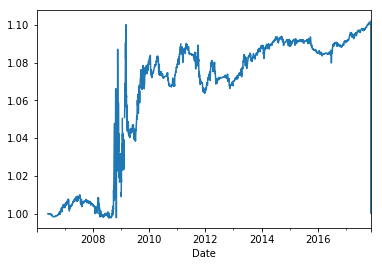

In [116]:
# 수익지수로 변환 후 그래프.(모멘텀 전략 수익지수)
to_index (trade_rets).plot()

In [121]:
# 연간 환산 표준편차는 변동성의 자표 > 샤프지수 계싼.
vol = pd.rolling_std(returns, 250, min_periods=200) * np.sqrt(250)

def sharpe(rets, ann=250):
    return rets.mean() / rets.std()  * np.sqrt(ann)

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250,min_periods=200,center=False).std()
  """Entry point for launching an IPython kernel.


In [123]:
cats = pd.qcut(vol, 4) # qcut 사분위로 나눔.
print('cats: %d, trade_rets: %d, vol: %d' % (len(cats), len(trade_rets), len(vol)))

cats: 3106, trade_rets: 3106, vol: 3106


In [125]:
trade_rets.groupby(cats).agg(sharpe)

Adj Close
(0.066, 0.113]    0.931350
(0.113, 0.147]    0.680152
(0.147, 0.189]   -0.128331
(0.189, 0.457]    0.359142
Name: Adj Close, dtype: float64

## 11.3: 추가 예제 애플리케이션(More example applications)

### 11.3.1: 신호 경계 분석(Signal frontier analysis)

In [23]:
yf.pdr_override()
names = ['AAPL', 'GOOG', 'MSFT','GS', 'MS', 'BAC', 'C'] # DELL 주식은 adj Close 에러나서 뺐음
def get_px(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Adj Close']
st = '2009-01-01'
nd = '2018-06-01'
px = DataFrame({n: get_px(n, st, nd) for n in names})

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [24]:
px

                  AAPL        BAC          C         GOOG          GS  \
Date                                                                    
2008-12-31    8.222328  13.012504  64.511612   152.830978   74.603447   
2009-01-02    8.742546  13.243549  68.645760   159.621811   76.698608   
2009-01-05    9.111515  12.920083  68.068916   162.965073   78.484337   
2009-01-06    8.961231  13.197339  71.722313   165.950653   78.422478   
2009-01-07    8.767592  12.670556  68.741882   159.964584   74.700706   
2009-01-08    8.930403  12.513443  68.838028   161.544312   75.505180   
...                ...        ...        ...          ...         ...   
2018-05-23  188.360001  30.316135  70.239998  1079.689941  236.972015   
2018-05-24  188.149994  30.087070  69.309998  1079.239990  235.268051   
2018-05-25  188.580002  30.037273  68.440002  1075.660034  234.181870   
2018-05-29  187.899994  28.842157  65.709999  1060.319946  226.229996   
2018-05-30  187.500000  29.370001  66.680000  1067.

In [25]:
# px = pd.read_csv('ch11/stock_px.csv')
# px

In [26]:
plt.close('all')

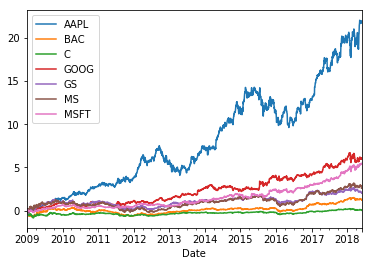

In [27]:
px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()
((1 + rets).cumprod()-1).plot()

In [28]:
# 포트폴리오 생성을 위한 특정 과거 모멘텀을 계산 후 내림차순 정렬 후 표준화.
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

In [29]:
# 변환함수를 이용하여 특정 과거의 포트폴리오와 보유기간(매매기간)을 계산하고 전체 샤프지수를 반환하는 백테스트 함수 준비.
compound = lambda x: (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices,lb,hold):
    # Compute portfolio weights(포트폴리오 가중치 계산)
    freq = '%dB'% hold
    port = calc_mom(prices, lb, lag=1)
    
    daily_rets = prices.pct_change()
    
    # Compute portfolio returns(포트폴리오 수익 계산)
    port = port.shift(1).resample(freq, how='first')
    returns = daily_rets.resample(freq, how=compound)
    port_rets = (port * returns).sum(axis=1)
    
    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [31]:
strat_sr(px, 70, 30)

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  del sys.path[0]
C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


0.077500463033796332

In [34]:
# 매개변수 그리드 위에서 strat_sr함수를 수행 후 defaultdict에 저장하고 dataframe으로 만듦.
from collections import defaultdict
lookbacks = range(20,90,5)
holdings = range(20,90,5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px,lb,hold)

ddf = DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  del sys.path[0]
C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


In [38]:
def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)    

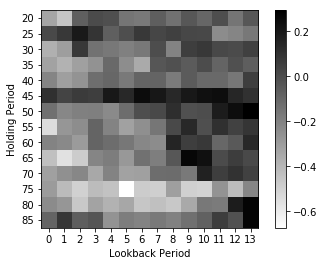

In [40]:
heatmap(ddf) # 히트맵 형식으로 결과보기.

### 11.3.2: 선물 계약 롤링(Future contract rolling)
- rolling(롤링) : 만기 거래에서 다음 거래로 갈아타는 것.
- 언제? 얼마나 빨리 실제로 만기계약을 거래하고 다음거래로 갈아타야할까? > 전략을 짤때 필요

In [41]:
pd.options.display.max_rows = 10

In [49]:
# S&P500 지수 대리로 SPY 장내거래펀드 가격을 사용.
px = web.get_data_yahoo('SPY','2010-01-02')['Adj Close'] * 10
px

[*********************100%***********************]  1 of 1 downloaded


Date
2010-01-04     955.28107
2010-01-05     957.80975
2010-01-06     958.48396
2010-01-07     962.53014
2010-01-08     965.73311
                 ...    
2018-06-11    2773.14758
2018-06-12    2776.73157
2018-06-13    2767.87109
2018-06-14    2774.84009
2018-06-15    2771.30005
Name: Adj Close, Length: 2128, dtype: float64

In [53]:
# S&P500 선물계약과 만기일을 Series에 저장.
from datetime import datetime
expiry = {'ESU2': datetime(2012, 9, 21),
          'ESZ2': datetime(2012, 12, 21)}
expiry = Series(expiry).sort_values()

In [55]:
expiry

ESU2   2012-09-21
ESZ2   2012-12-21
dtype: datetime64[ns]

In [56]:
# 야후! 금융가격정보를 임의적으로 약간 변경하여 두계약을 선물로 가정.
np.random.seed(12347)
N = 200
walk = (np.random.randint(0,200, size=N) - 100) * 0.25
perturb = (np.random.randint(0,20, size=N) - 10) * 0.25
walk = walk.cumsum()

rng = pd.date_range(px.index[0], periods=len(px)+N, freq='B')
near = np.concatenate([px.values, px.values[-1] + walk])
far = np.concatenate([px.values, px.values[-1] + walk + perturb])
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

In [58]:
prices.tail()

                  ESU2        ESZ2
2018-11-29  2800.55005  2802.30005
2018-11-30  2786.80005  2789.05005
2018-12-03  2794.80005  2796.55005
2018-12-04  2811.30005  2810.55005
2018-12-05  2791.30005  2789.05005

In [60]:
# 가중행렬 생성 : 2개의 시계열을 하나의 연속된 시계열로 이어붙이는 방법 중 하나.
# 만기일까지 가중치 1 > 유효한 계약 
# 만기일이 되면 롤링여부 결정해야함

## 만기까지 기간에 대한 선형붕괴값으로 계산한 가중행렬함수.
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : 가중 DataFrame을 계산하기 위한 시작일
    # expiry : 종목 Series > 만기일
    # items : 계약 이름 리스트

    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = DataFrame(np.zeros((len(dates), len(items))),
                        index=dates, columns=items)

    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.ix[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')

            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, item] = 1 - decay_weights
            weights.ix[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, item] = 1

        prev_date = ex_date

    return weights

In [63]:
# 만기일 부근에서의 가중치
weights = get_roll_weights('6/1/2012', expiry, prices.columns)
weights.ix['2012-09-12':'2012-09-21']

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


            ESU2  ESZ2
2012-09-12   1.0   0.0
2012-09-13   1.0   0.0
2012-09-14   0.8   0.2
2012-09-17   0.6   0.4
2012-09-18   0.4   0.6
2012-09-19   0.2   0.8
2012-09-20   0.0   1.0
2012-09-21   0.0   1.0

In [67]:
# 갈아탄 선물 수익 = 계약수익의 가중합과 같다.
rolling_returns = (prices.pct_change() * weights).sum(1)
rolling_returns.ix['2012-09-12':'2012-09-21']

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


2012-09-12    0.008328
2012-09-13    0.010133
2012-09-14    0.004535
2012-09-17   -0.002599
2012-09-18   -0.016664
2012-09-19    0.000139
2012-09-20   -0.013876
2012-09-21   -0.002828
Freq: B, dtype: float64

### 11.3.3: 롤링 상관관계와 선형회귀(Rolling correlation and linear regression)
- 동적모델 : 금융모델에서 중요한 역할, 어떤기간에서 매매결정을 시뮬레이션하는데 사용.
- (예) 이동창, 지수 가중 시계열 함수.

In [69]:
# 상관관계 : 두 자산의 시계열상에서 서로간의 변화를 살펴볼 수 있는 한 방법.
# rolling_corr함수를 반환된 두 시계열과 함계 호출하여 이동창의 상관관계 산출.
# 야후! 주식정보 > 일별수익 계산
aapl = web.get_data_yahoo('AAPL','2000-01-01')['Adj Close']
msft = web.get_data_yahoo('MSFT','2000-01-01')['Adj Close']

aapl_rets = aapl.pct_change()
msft_rets = msft.pct_change()

aapl_rets
msft_rets

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


Date
1999-12-31         NaN
2000-01-03    0.088754
2000-01-04   -0.084310
2000-01-05    0.014634
2000-01-06   -0.086538
                ...   
2018-06-11   -0.002452
2018-06-12    0.005491
2018-06-13   -0.008217
2018-06-14    0.000524
2018-06-15   -0.010273
Name: Adj Close, Length: 4644, dtype: float64

Date
1999-12-31         NaN
2000-01-03   -0.001606
2000-01-04   -0.033780
2000-01-05    0.010544
2000-01-06   -0.033498
                ...   
2018-06-11   -0.005707
2018-06-12    0.002573
2018-06-13   -0.004541
2018-06-14    0.005652
2018-06-15   -0.012719
Name: Adj Close, Length: 4644, dtype: float64

In [72]:
plt.figure()

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250).corr(other=<Series>)
  This is separate from the ipykernel package so we can avoid doing imports until


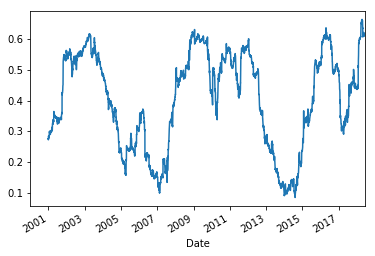

In [78]:
# 애플과 마이크로소프트의 연간 상관관계
# 두 자산 간의 상관관계 : 유동성의 차이를 잡아내지 못함.
pd.rolling_corr(aapl_rets, msft_rets, 250).plot()

In [76]:
plt.figure()

In [106]:
# 최소제곱 회귀분석 : 한 변수와 다른예측변수 사이의 동적관계를 모델링하는 또 다른 방법.
import statsmodels.api as sm
y = aapl_rets
dfX0 = msft_rets
X = sm.add_constant(dfX0)
model = sm.OLS(y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 16 Jun 2018   Prob (F-statistic):                nan
Time:                        20:00:29   Log-Likelihood:                    nan
No. Observations:                4644   AIC:                               nan
Df Residuals:                    4644   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\numpy\linalg\linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)
C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\hwany\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1348: RuntimeWarning: invalid value encountered in less
  term2 = np.where(denom < 0, term1, np.power((1-2.0/A)/denom, 1/3.0))
